Données chargées avec succès. Dimensions: (335, 20)


C:\Users\AudreyHay\AppData\Local\Temp\ipykernel_54324\1037429389.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['souris_id'] = df_test['mice']


Graphique pour total_distance_cm créé.


<Figure size 1500x1000 with 0 Axes>

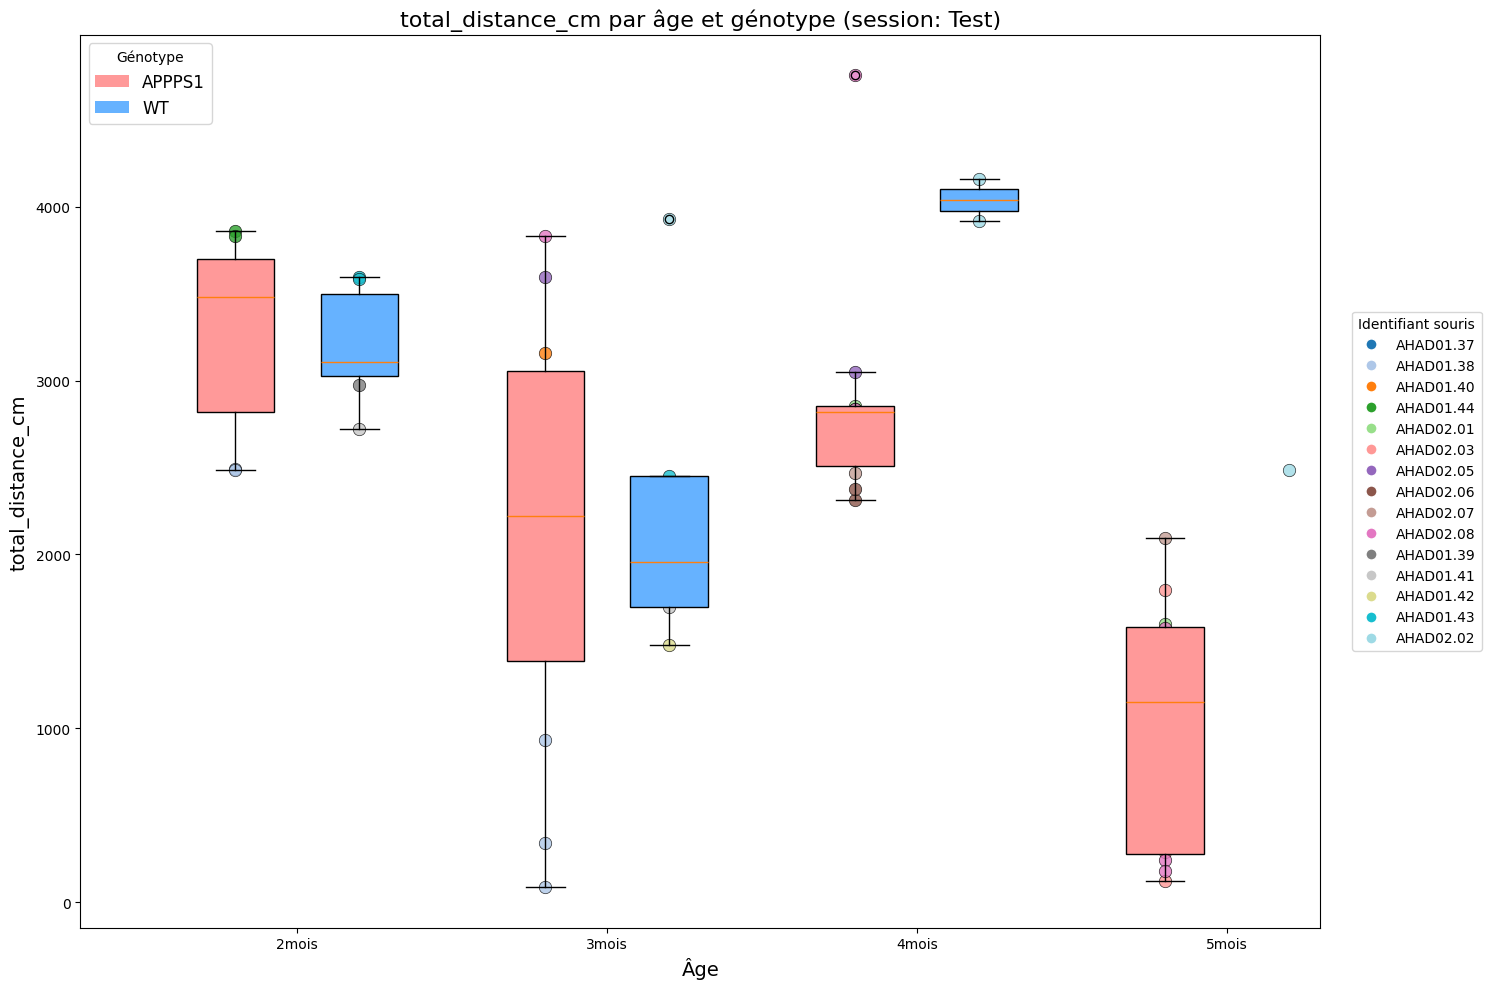

Graphique pour average_speed créé.


<Figure size 1500x1000 with 0 Axes>

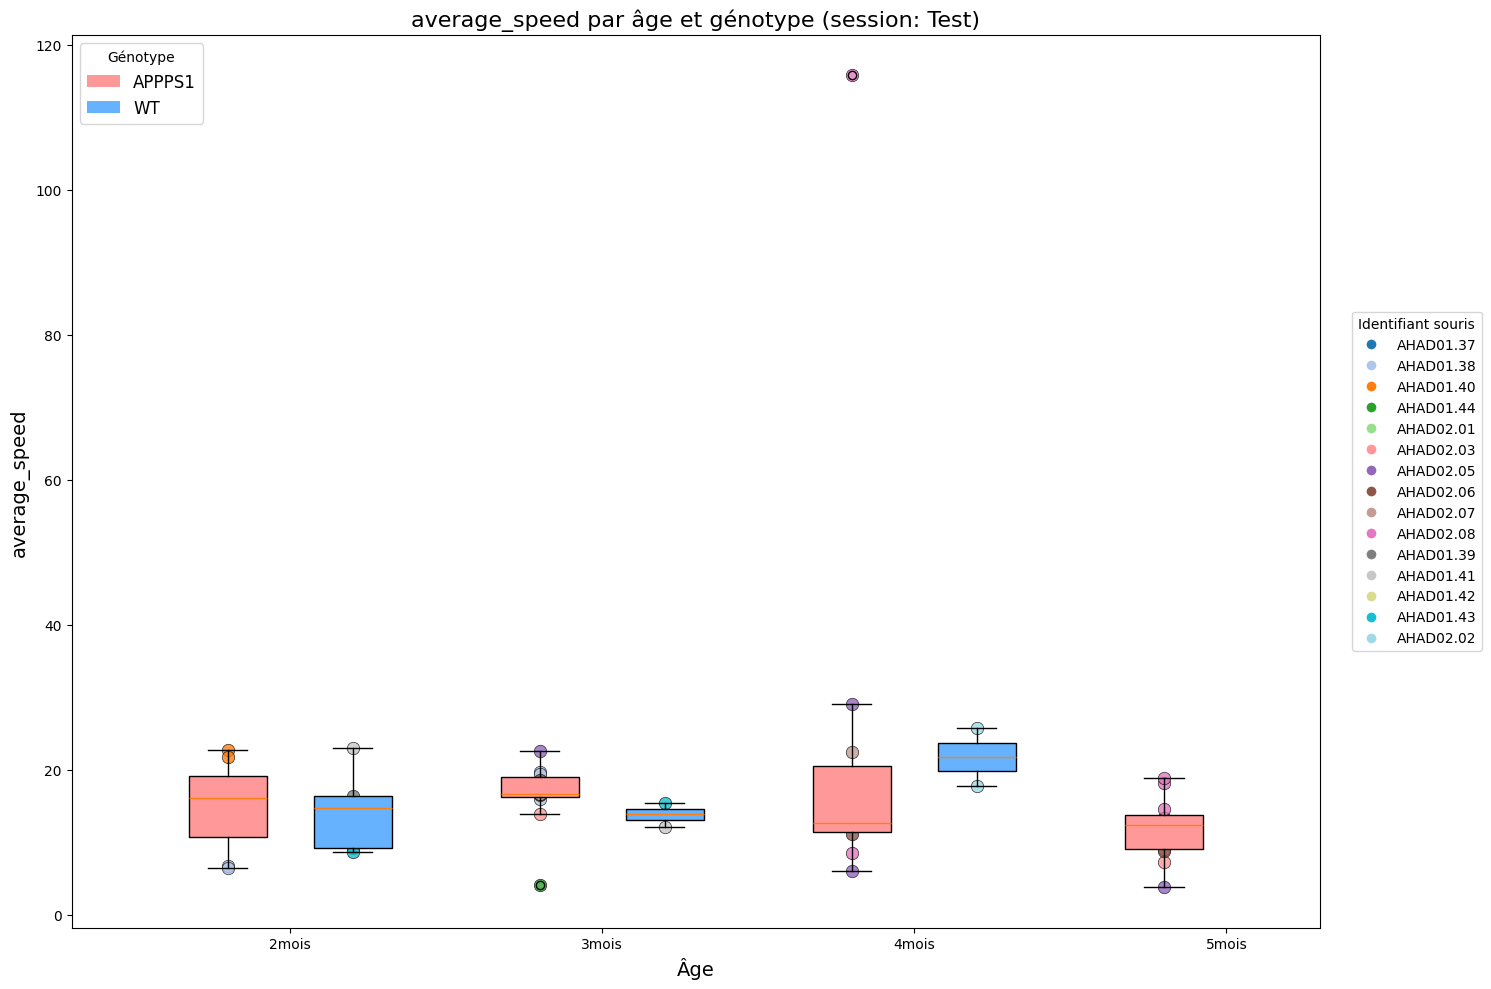

Graphique pour latency_to_reward_s créé.


<Figure size 1500x1000 with 0 Axes>

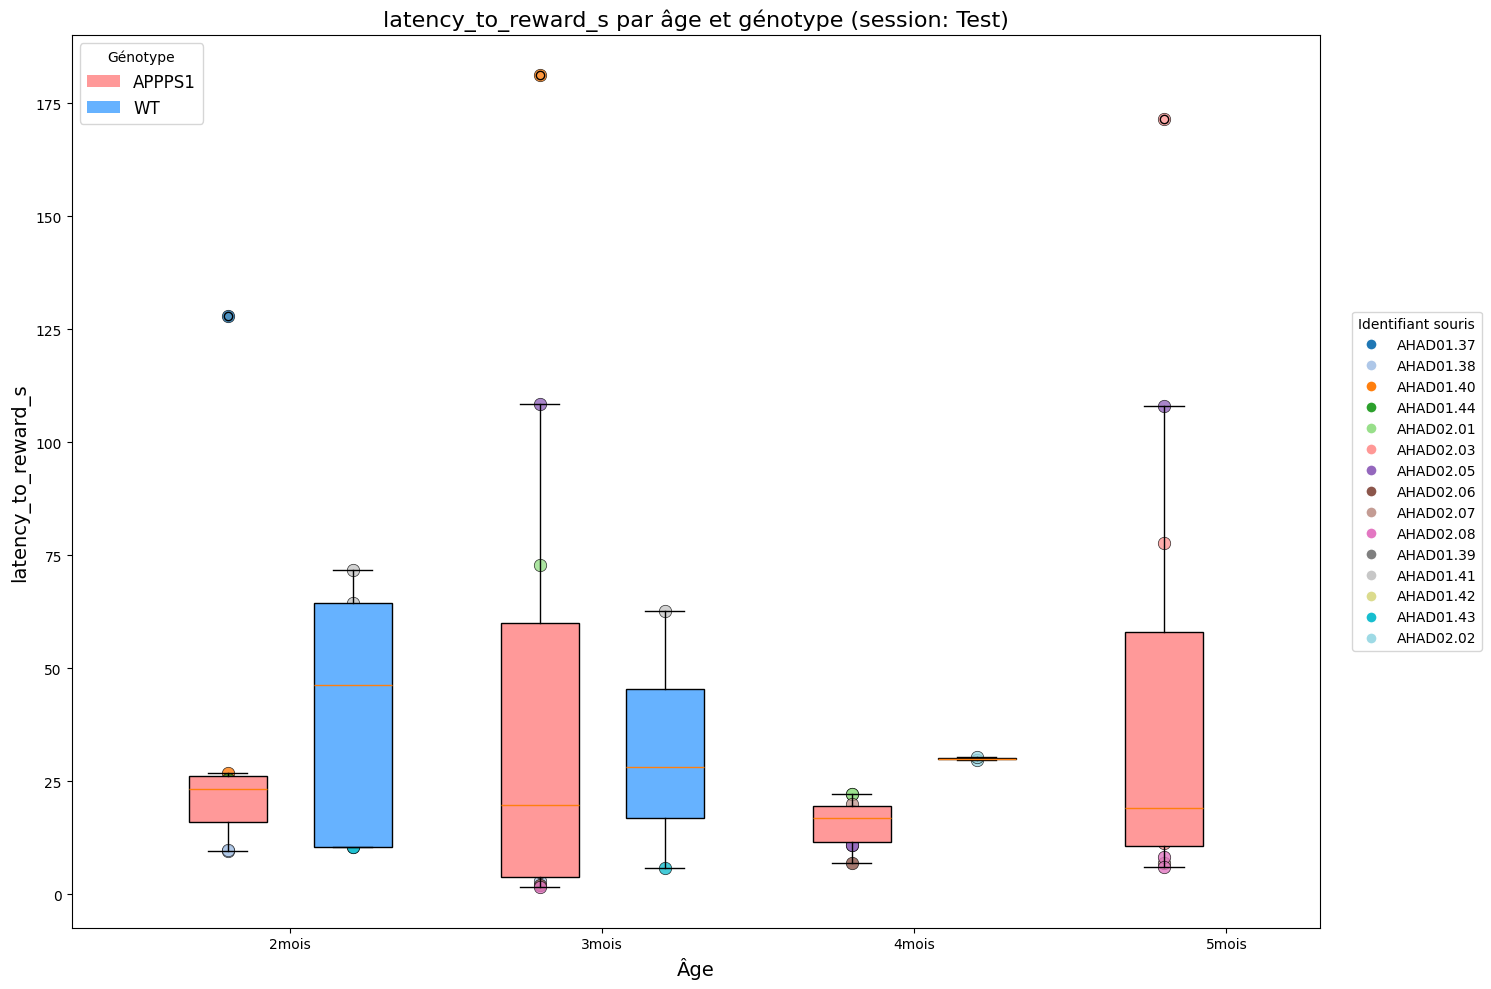

Graphique pour time_spent_at_reward_s créé.


<Figure size 1500x1000 with 0 Axes>

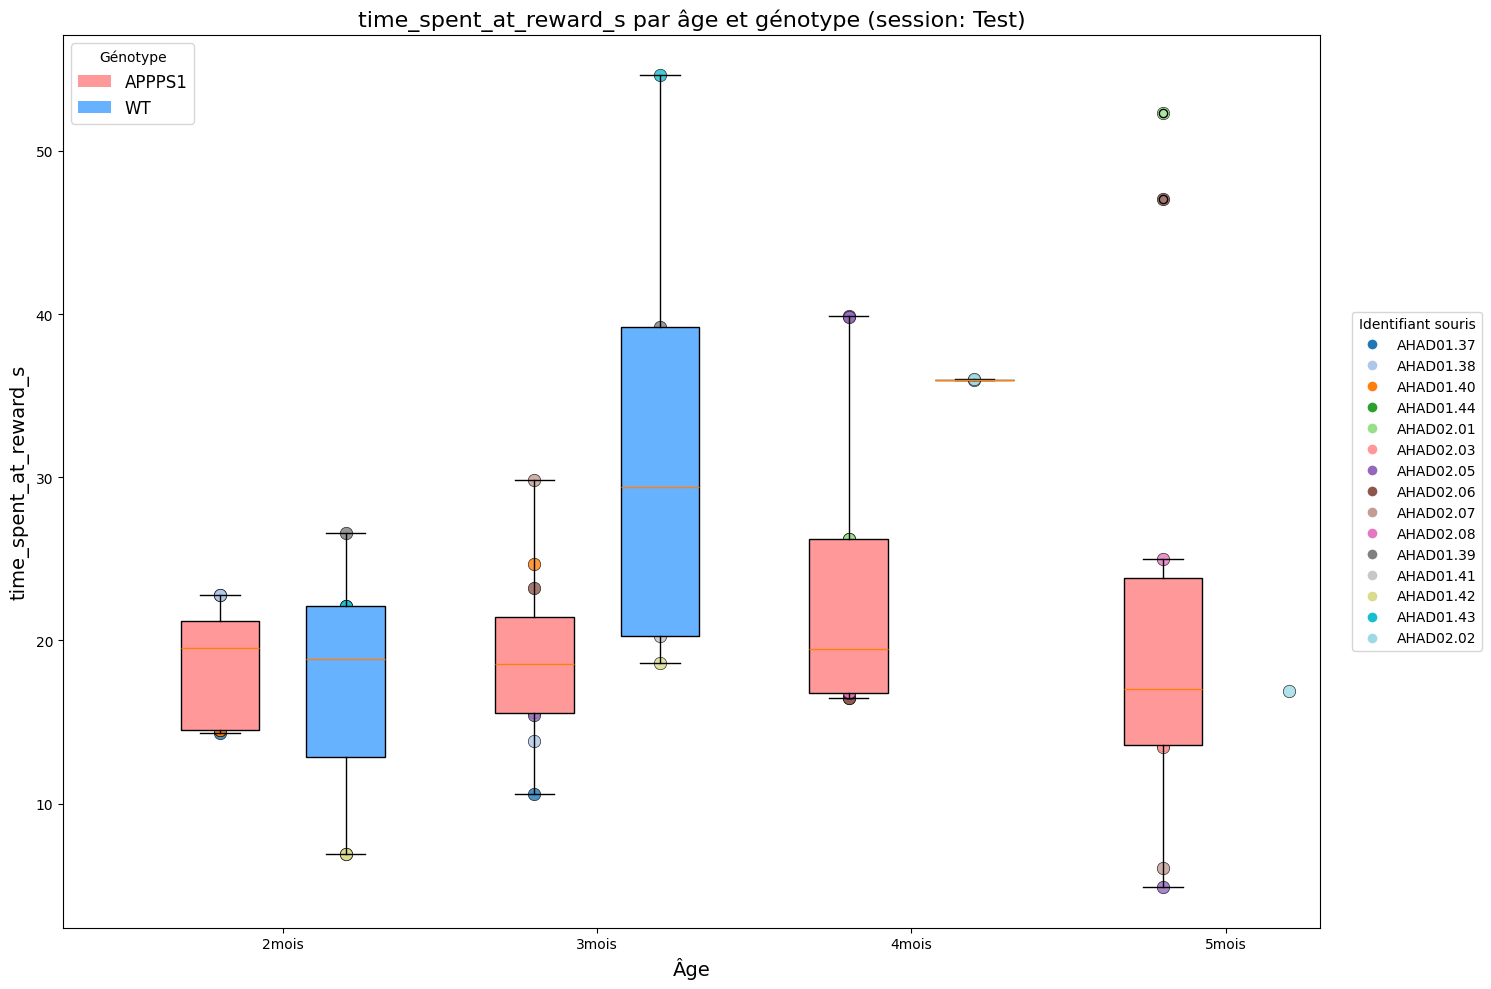

Graphique pour distance_to_reward_cm créé.


<Figure size 1500x1000 with 0 Axes>

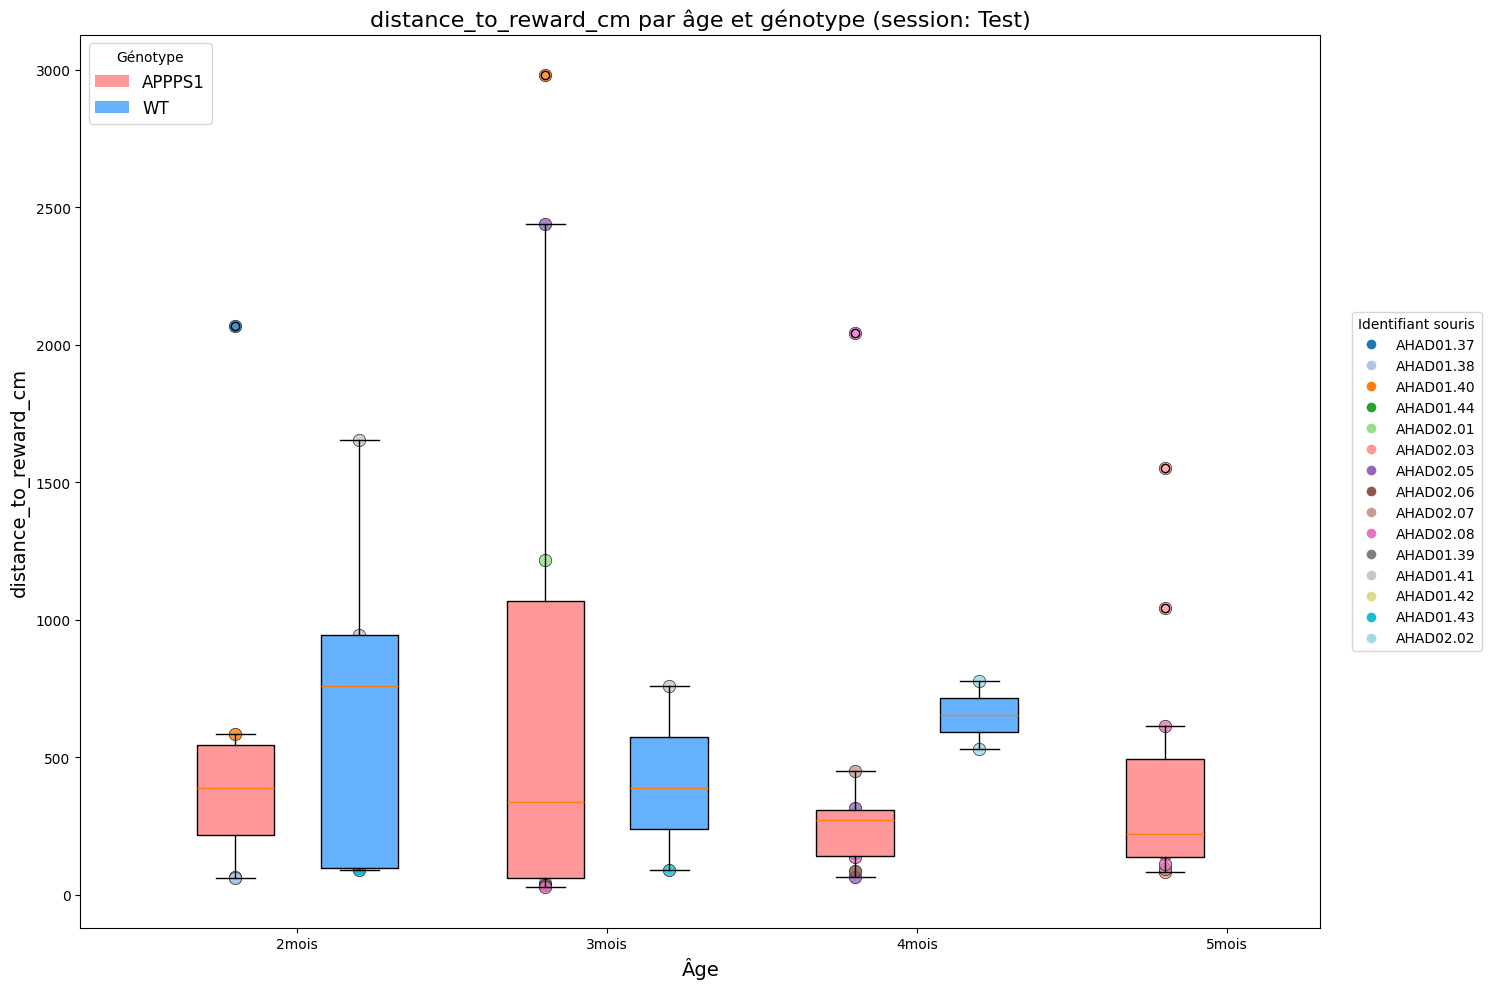

Graphique pour crossings créé.


<Figure size 1500x1000 with 0 Axes>

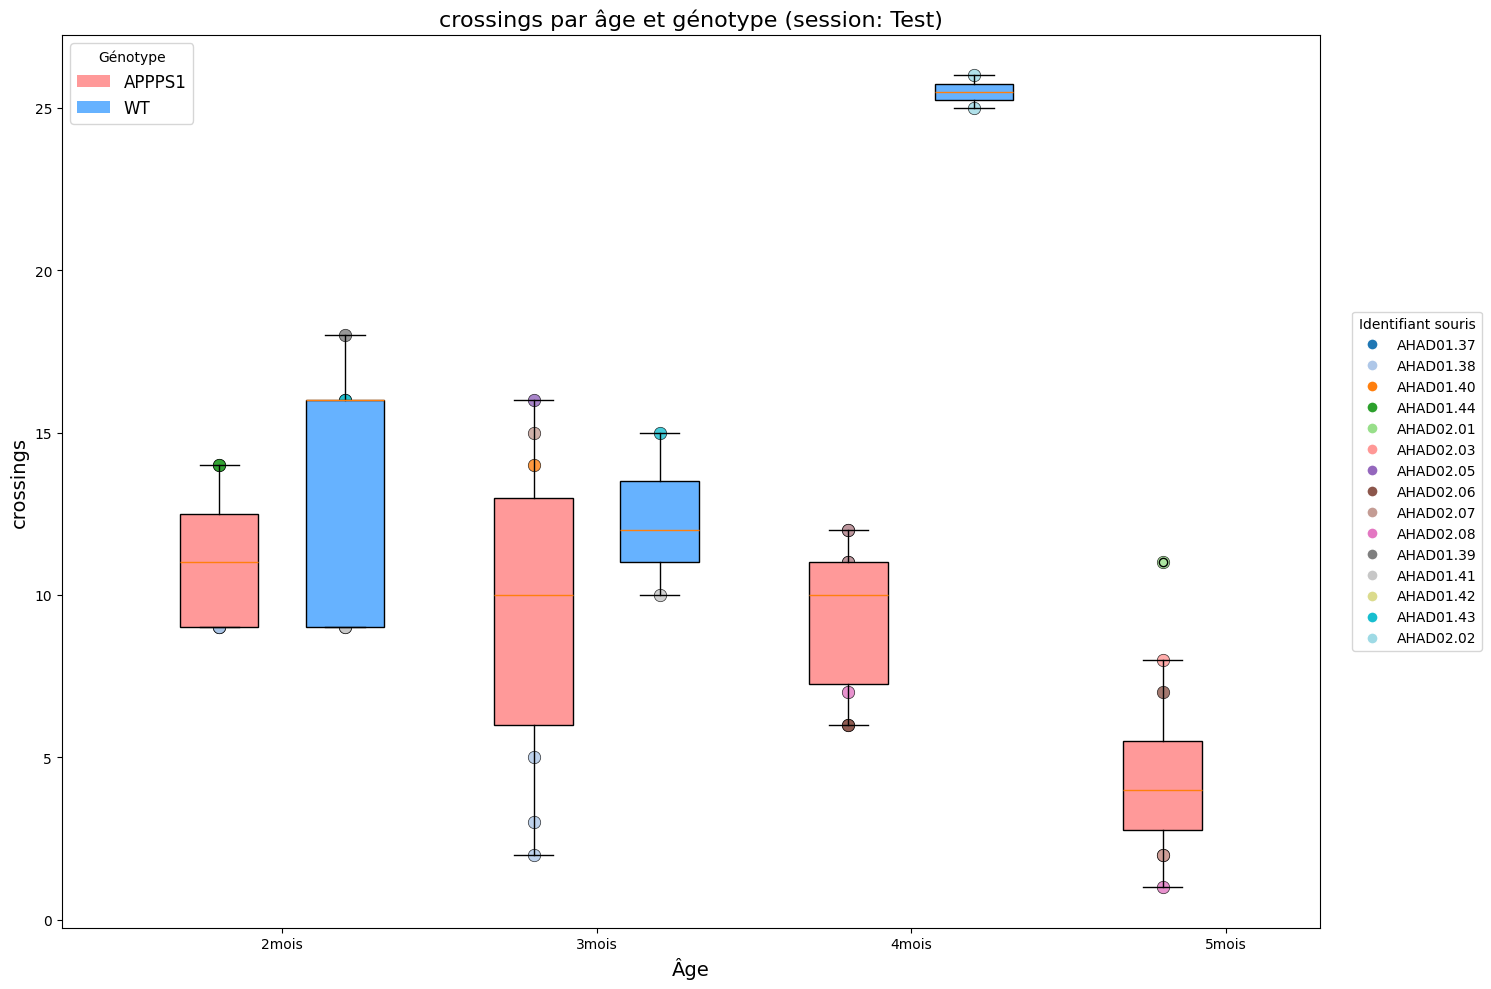

Graphique pour crossings_per_m créé.


<Figure size 1500x1000 with 0 Axes>

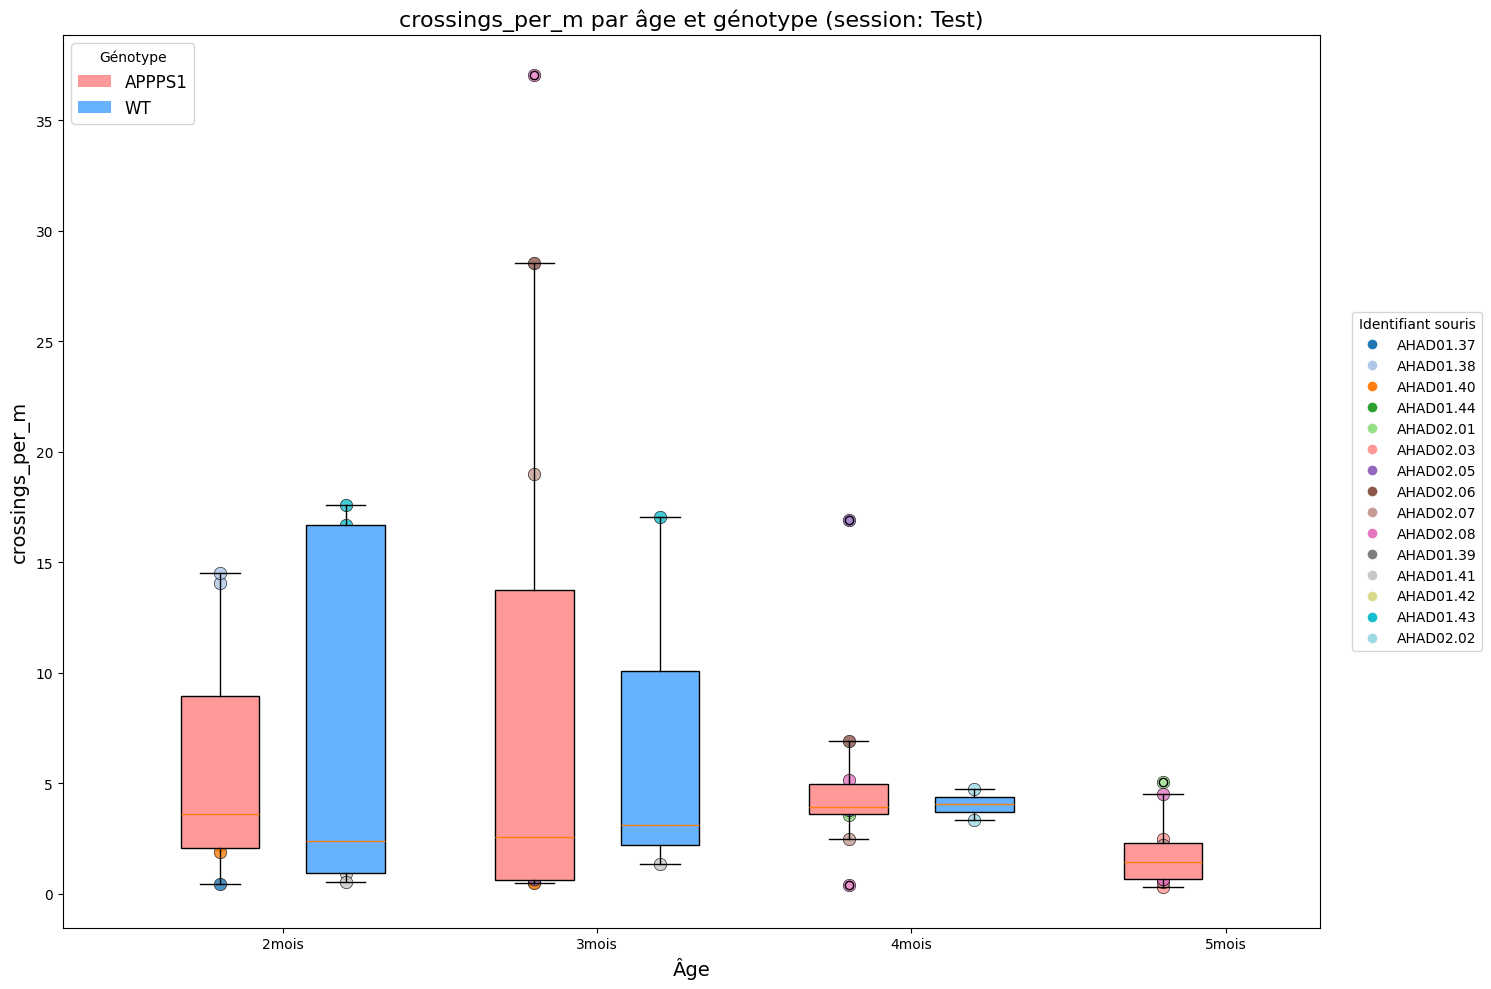


Statistiques descriptives par génotype et âge:
               total_distance_cm                                     \
                           count         mean          std      min   
genotype age                                                          
APPPS1   2mois               7.0  3264.440000   581.610880  2485.59   
         3mois              12.0  2092.165000  1215.946299    87.61   
         4mois              10.0  2892.299000   695.949294  2315.15   
         5mois              12.0  1014.465000   692.802334   120.50   
WT       2mois               7.0  3210.475714   328.505766  2723.17   
         3mois               5.0  2302.498000   978.993888  1478.28   
         4mois               2.0  4038.375000   173.912913  3915.40   
         5mois               1.0  2485.140000          NaN  2485.14   

                                                        average_speed  \
                      25%       50%        75%      max         count   
genotype age            

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D  # For custom legend

def analyser_donnees_souris(fichier, session_type_cible='Test'):
    # Load data
    try:
        df = pd.read_csv(fichier)
    except:
        try:
            df = pd.read_excel(fichier)
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier: {e}")
            return
    
    print(f"Données chargées avec succès. Dimensions: {df.shape}")
    
    # Filter for test sessions
    df_test = df[df['session_type'] == session_type_cible]
    
    if df_test.empty:
        print(f"Aucune donnée trouvée pour session_type = {session_type_cible}")
        return
    
    # Parameters to analyze
    parametres = [
        'total_distance_cm', 'average_speed', 'latency_to_reward_s', 
        'time_spent_at_reward_s', 'distance_to_reward_cm', 
        'crossings', 'crossings_per_m'
    ]
    
    # Sort ages chronologically
    ages_uniques = sorted(df_test['age'].unique())
    
    # Create mouse identifier
    if 'mice' not in df_test.columns:
        if 'genotype' in df_test.columns:
            df_test['souris_id'] = df_test['genotype'] + '_' + df_test['age'].astype(str) + '_' + df_test.index.astype(str)
        else:
            df_test['souris_id'] = 'Souris_' + df_test.index.astype(str)
    else:
        df_test['souris_id'] = df_test['mice']
    
    # Create plot for each parameter
    for parametre in parametres:
        if parametre not in df_test.columns:
            print(f"Le paramètre {parametre} n'est pas dans les données.")
            continue
        
        # Filter for APPPS1 and WT
        df_filtered = df_test[df_test['genotype'].isin(['APPPS1', 'WT'])]
        
        if df_filtered.empty:
            print(f"Pas de données pour les génotypes APPPS1 ou WT pour le paramètre {parametre}")
            continue
            
        # Check if the parameter has any valid data
        if df_filtered[parametre].isna().all():
            print(f"Toutes les valeurs sont NaN pour le paramètre {parametre}. Graphique ignoré.")
            continue
        
        # Create figure
        plt.figure(figsize=(15, 10))
        
        # Create color palette for individual mice
        souris_uniques = df_filtered['souris_id'].unique()
        n_souris = len(souris_uniques)
        couleurs = plt.cm.tab20(np.linspace(0, 1, n_souris))
        souris_couleurs = dict(zip(souris_uniques, couleurs))
        
        # Create plot - use try/except for more robust plotting
        try:
            # Initialize the axes manually to avoid issues with empty groups
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.grid(False)
            
            # Track if we have valid data to plot
            has_valid_data = False
            
            # Process each genotype and age group
            genotype_colors = {'APPPS1': '#FF9999', 'WT': '#66B2FF'}
            pos_offset = {'APPPS1': -0.2, 'WT': 0.2}
            
            for genotype in ['APPPS1', 'WT']:
                for age_idx, age in enumerate(ages_uniques):
                    # Get data subset
                    subset = df_filtered[(df_filtered['genotype'] == genotype) & 
                                        (df_filtered['age'] == age)]
                    
                    # Skip empty subsets
                    if subset.empty or subset[parametre].isna().all():
                        continue
                    
                    has_valid_data = True
                    
                    # Position for this group
                    x_pos = age_idx + pos_offset[genotype]
                    
                    # Create boxplot if we have at least 2 data points
                    if len(subset) >= 2:
                        bp = ax.boxplot(subset[parametre].dropna(), 
                                       positions=[x_pos], 
                                       widths=0.25,
                                       patch_artist=True, 
                                       boxprops=dict(facecolor=genotype_colors[genotype]))
                    
                    # Add individual data points
                    for _, row in subset.iterrows():
                        if pd.notna(row[parametre]):  # Only plot non-NaN values
                            ax.scatter(x_pos, row[parametre], 
                                      color=souris_couleurs[row['souris_id']], 
                                      s=80, alpha=0.8, edgecolor='k', linewidth=0.5)
            
            # If we have no valid data, skip this parameter
            if not has_valid_data:
                plt.close()
                print(f"Aucune donnée valide pour le paramètre {parametre}. Graphique ignoré.")
                continue
                
            # Set x-axis ticks and labels
            ax.set_xticks(range(len(ages_uniques)))
            ax.set_xticklabels([str(age) for age in ages_uniques])  # Ensure string type
            
            # Add labels and title
            ax.set_xlabel('Âge', fontsize=14)
            ax.set_ylabel(parametre, fontsize=14)
            ax.set_title(f'{parametre} par âge et génotype (session: {session_type_cible})', fontsize=16)
            
            # Create genotype legend
            from matplotlib.patches import Patch
            legend_elements_genotype = [
                Patch(facecolor='#FF9999', label='APPPS1'),
                Patch(facecolor='#66B2FF', label='WT')
            ]
            
            # Add the first legend in the upper left
            first_legend = ax.legend(handles=legend_elements_genotype, title='Génotype', 
                                    loc='upper left', fontsize=12)
            ax.add_artist(first_legend)
            
            # Create mouse legend if there aren't too many mice
            if n_souris <= 20:  # Only add individual mouse legend if not too many
                legend_elements_souris = []
                for souris_id, couleur in souris_couleurs.items():
                    legend_elements_souris.append(Line2D([0], [0], marker='o', color='w', 
                                                     markerfacecolor=couleur, markersize=8, 
                                                     label=souris_id))
                
                ax.legend(handles=legend_elements_souris, title='Identifiant souris', 
                        loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10)
            
            # Adjust x-axis labels if necessary
            if len(ages_uniques) > 5:
                plt.xticks(rotation=45)
            
            # Adjust layout
            plt.tight_layout()
            
            # Save plot
            plt.savefig(f'{parametre}_par_age_et_genotype_avec_points.png', dpi=300, bbox_inches='tight')
            print(f"Graphique pour {parametre} créé.")
            
            # Show plot
            plt.show()
            
        except Exception as e:
            plt.close()  # Close the figure to avoid displaying errors
            print(f"Erreur lors de la création du graphique pour {parametre}: {e}")
            
    # Descriptive statistics by genotype and age
    print("\nStatistiques descriptives par génotype et âge:")
    stats = df_test.groupby(['genotype', 'age'])[parametres].describe()
    return stats

# Example usage
if __name__ == "__main__":
    # Path to your Excel file
    fichier = r"C:\Users\AudreyHay\Documents\Carla\Cheeseboard\Summary_table.xlsx"
    
    # Run analysis
    try:
        stats = analyser_donnees_souris(fichier)
        
        # Display statistics (optional)
        if stats is not None:
            print(stats)
    except Exception as e:
        print(f"Erreur globale: {e}")
        import traceback
        traceback.print_exc()